# Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import nltk
import re
from wordcloud import WordCloud

# Dataset

In [5]:
train = pd.read_csv('./datasets/sentiment140_train.csv', header=None, error_bad_lines=False, encoding='latin-1')
train.columns = ['label', 'id', 'date', 'query', 'user', 'text']
train.head()

,label,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
train.drop(['id', 'date', 'query', 'user'], inplace=True, axis=1)
train.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
label    1600000 non-null int64
text     1600000 non-null object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [8]:
train['label'].unique()

array([0, 4], dtype=int64)

# Exploration

In [9]:
all_words = []
for text in train['text']:
    for word in text.split():
        all_words.append(word.lower())

In [10]:
from collections import Counter

Counter(all_words).most_common(10)

[('i', 746635),
 ('to', 560314),
 ('the', 518734),
 ('a', 376422),
 ('my', 312846),
 ('and', 295675),
 ('you', 237766),
 ('is', 231086),
 ('for', 214051),
 ('in', 209960)]

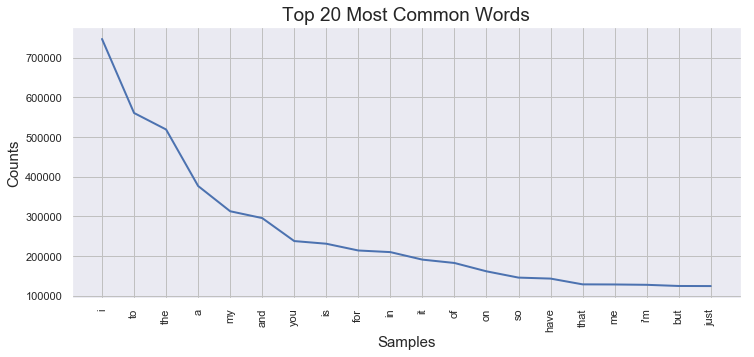

In [11]:
plt.figure(figsize=(12, 5))
plt.title("Top 20 Most Common Words", fontsize=19)
plt.xlabel('Word', fontsize=15)
plt.ylabel('Count', fontsize=15)
fd = nltk.FreqDist(all_words)
fd.plot(20)
plt.show()

# Pre-processing

## Basic Stripping

In [12]:
def preprocess_tweet(tweet):
    # remove HTML links
    tweet = re.sub("r'https?:\/\/.*\/\w*'", '', tweet)
    # remove @user handles
    tweet = re.sub("@[\w]*", '', tweet)
    # remove punctuation and special characters
    tweet = re.sub("[^a-zA-Z#]", ' ', tweet)
    # lowercase conversion
    tweet = tweet.lower()
    # remove words of length 3 or less
    tweet = ' '.join([word for word in tweet.split() if len(word) > 3])
    
    return tweet

In [13]:
train['text'] = train['text'].apply(preprocess_tweet)

In [14]:
train.head()

,label,text
0,0,http twitpic awww that bummer shoulda david ca...
1,0,upset that update facebook texting might resul...
2,0,dived many times ball managed save rest bounds
3,0,whole body feels itchy like fire
4,0,behaving here because over there


## Tokenization

In [15]:
train['tokens'] = train['text'].apply(lambda x: x.split())

## Stemming

In [16]:
from nltk.stem.porter import *

stemmer = PorterStemmer()
train['tokens'] = train['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])
train['text'] = train['tokens'].apply(lambda x: ' '.join([word for word in x]))
train.head()

,label,text,tokens
0,0,http twitpic awww that bummer shoulda david ca...,"[http, twitpic, awww, that, bummer, shoulda, d..."
1,0,upset that updat facebook text might result sc...,"[upset, that, updat, facebook, text, might, re..."
2,0,dive mani time ball manag save rest bound,"[dive, mani, time, ball, manag, save, rest, bo..."
3,0,whole bodi feel itchi like fire,"[whole, bodi, feel, itchi, like, fire]"
4,0,behav here becaus over there,"[behav, here, becaus, over, there]"


# Visualization

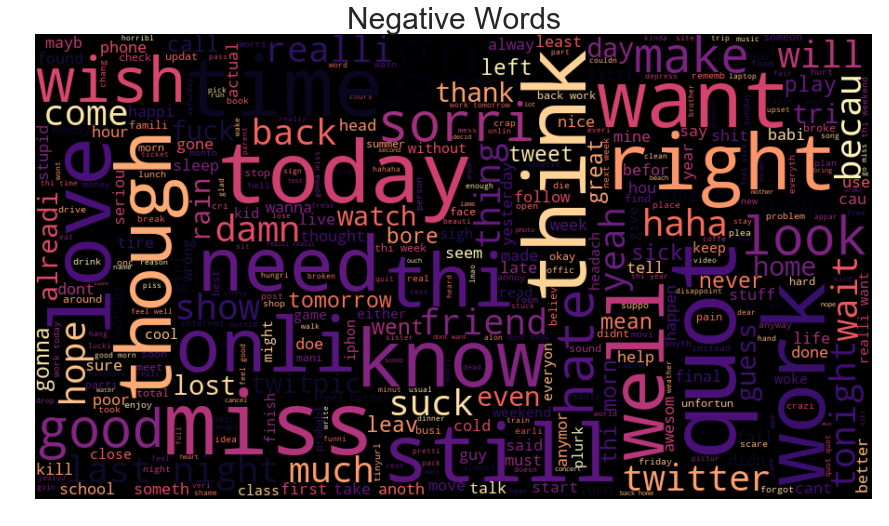

In [17]:
neg_tweets = train['text'][train['label'] == 0]

neg_wordcloud = WordCloud(width=900, height=500, max_words=400, max_font_size=100, 
                          colormap='magma').generate(' '.join(tweet for tweet in neg_tweets))
plt.figure(figsize=(15, 12))
plt.imshow(neg_wordcloud, interpolation="bilinear")
plt.title('Negative Words', fontsize=30)
plt.axis('off')
plt.show()

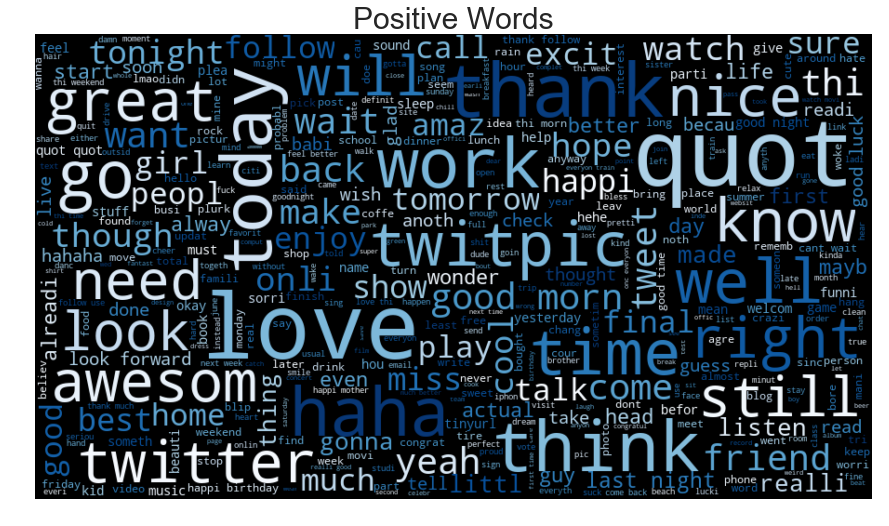

In [18]:
pos_tweets = train['text'][train['label'] == 4]

pos_wordcloud = WordCloud(width=900, height=500, max_words=400, max_font_size=100, 
                          colormap='Blues').generate(' '.join(tweet for tweet in pos_tweets))
plt.figure(figsize=(15, 12))
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.title('Positive Words', fontsize=30)
plt.axis('off')
plt.show()

# Feature Extraction

## Bag-of-Words

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(stop_words='english')
bow = bow_vectorizer.fit_transform(train['text'])

## TF-IDF

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(train['text'])

# Model Training

In [21]:
from sklearn.model_selection import train_test_split

X_train_bow, X_val_bow, y_train_bow, y_val_bow = train_test_split(bow, train['label'], test_size=0.2)
X_train_tfidf, X_val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(tfidf, train['label'], test_size=0.2)

In [22]:
from sklearn.metrics import accuracy_score

def evaluate_model(model, title):
    model.fit(X_train_bow, y_train_bow)
    y_pred_bow = model.predict(X_val_bow)
    print("{} - Bag-of-Words accuracy: {}".format(title, accuracy_score(y_val_bow, y_pred_bow)))
    
    model.fit(X_train_tfidf, y_train_tfidf)
    y_pred_tfidf = model.predict(X_val_tfidf)
    print("{} - TF-IDF accuracy: {}".format(title, accuracy_score(y_val_tfidf, y_pred_tfidf)))

## Naive Bayes

In [23]:
from sklearn.naive_bayes import MultinomialNB

MNB = MultinomialNB()
evaluate_model(MNB, "Naive Bayes")

Naive Bayes - Bag-of-Words accuracy: 0.747040625
Naive Bayes - TF-IDF accuracy: 0.74381875


## Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
evaluate_model(lr, "Logistic Regression")

C:\Users\Brenno Ribeiro\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression - Bag-of-Words accuracy: 0.7555125
Logistic Regression - TF-IDF accuracy: 0.758190625


## Decision Tree

In [21]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
evaluate_model(tree, "Decision Tree")

0.695209375 - Bag-of-Words accuracy: Decision Tree
0.6994375 - TF-IDF accuracy: Decision Tree


## Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
evaluate_model(rf, "Random Forest")

C:\Users\Brenno Ribeiro\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.72956875 - Bag-of-Words accuracy: Random Forest
0.730675 - TF-IDF accuracy: Random Forest


# Fine Tuning

In [25]:
from sklearn.model_selection import GridSearchCV

param_distrib = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(0, 5, 10)
}

lr_grid = LogisticRegression()

grid_search = GridSearchCV(lr_grid, param_distrib, cv=5, scoring="accuracy")
grid_search.fit(X_train_tfidf, y_train_tfidf)

C:\Users\Brenno Ribeiro\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brenno Ribeiro\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.00000e+00, 3.59381e+00, 1.29155e+01, 4.64159e+01, 1.66810e+02,
       5.99484e+02, 2.15443e+03, 7.74264e+03, 2.78256e+04, 1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [26]:
grid_search.best_score_

0.75586171875

In [27]:
grid_search.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)